**Tecnológico de Monterrey**

**Maestría en Inteligencia Artificial Aplicada**

**ASIGNATURA: Proyecto Integrador**

**PROFESOR TITULAR: Dra. Grettel Barceló Alonso**

**ACTIVIDAD:Avance 4. Modelos Alternativos**

---
**EQUIPO 3**

*   Rayan Bahrein García Fabián - A01204055
*   Brandon Alexis del Ángel Gómez - A01795429
*   Fernando Jiménez Pereyra - A01734609

## Resumen ejecutivo


### Objetivo

Esta fase tuvo como finalidad desarrollar un sistema de recomendación que permita predecir el nivel de contribución de colaboradores asignados a proyectos, con el propósito de asistir a los Project Managers en la selección de talento con mayor potencial de impacto.

### Metodología

Se abordaron tres tareas predictivas independientes para evaluar y optimizar diferentes estrategias de modelado:

1. Regresión: Predicción del `contribution_score` como variable continua.
2. Clasificación binaria: Identificación de candidatos con contribución alta (`score ≥ 70`).
3. Clasificación multiclase: Segmentación en niveles Bajo, Medio y Alto según el `contribution_score`.

Cada tarea incluyó:

* Preprocesamiento de datos con escalado y codificación categórica.
* Entrenamiento y evaluación de múltiples modelos base e híbridos (ensembles).
* Comparación de métricas, tiempo de entrenamiento, y complejidad para determinar los mejores modelos.
* Interpretación visual mediante gráficos de residuos, curvas ROC y precisión-recall.


### Modelos Construidos

Se entrenaron modelos individuales y posteriormene se desarrollaron modelos de ensamble homogéneos y heterogéneos (Bagging, Boosting, Stacking).


### Principales Hallazgos

#### 1. Regresión – Modelo Final: RandomForestRegressor

* MAE: 3.61 | R²: 0.80 | RMSE: 20.03
* Modelo robusto, con buen ajuste y errores distribuidos de forma razonable.
* Análisis de residuos mostró ligeros patrones, pero sin evidencia clara de sesgo.

#### 2. Clasificación Binaria – Modelo Final: GradientBoostingClassifier

* Accuracy: 0.669 | F1: 0.756 | AUC: 0.722
* Buen balance entre precisión y recall.
* Logra identificar correctamente un alto porcentaje de casos positivos sin sacrificar demasiado la precisión.
* Gráficos interpretativos (ROC, PRC, matriz de confusión) mostraron un desempeño equilibrado, aunque con espacio para mejora en recall.

#### 3. Clasificación Multiclase – Modelo Final: StackingClassifier

* Accuracy: 0.736 | F1 ponderado: 0.694
* Las predicciones se concentran fuertemente en la clase “Medio”, lo que sugiere riesgo de sesgo en clases minoritarias (“Alto” y “Bajo”).
* La clase “Alto”, clave para la toma de decisiones, presenta un recall bajo.


### Conclusión

* El modelo de Random Forest para regresión es adecuado para predecir contribuciones esperadas de forma continua.
* En tareas operativas de clasificación, el modelo Gradient Boosting para binaria ofrece mejor balance de rendimiento y eficiencia.


## Importación de librerías y carga de datos

In [ ]:
import pandas as pd
import numpy as np
import time
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, log_loss
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.preprocessing import label_binarize

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBClassifier

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingRegressor

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import StackingClassifier

import os

import matplotlib.pyplot as plt
import seaborn as sns

El dataset con el que trabajamos fue generado en los pasos anteriores de procesamiento, limpieza e ingeniería de características.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df = pd.read_csv('dataset_modelo_baseline.csv')
df = pd.read_csv('/content/drive/MyDrive/Poyecto/Datos/dataset_modelo_baseline.csv')

## A. Modelos de ensamble

Creación de modelos de ensamble con regresión, clasificación binaria y multiclase.

### A.1 Modelos de ensamble con regresión

Consturimos modelos de ensamble con regresión, utilizando los modelos previamente optimizados, enfocándonos en bagging, boosting y stacking.

#### Dataset y features

In [ ]:
def clasificar_score(score):
    if score < 65:
        return 'Bajo'
    elif score < 80:
        return 'Medio'
    else:
        return 'Alto'

df['score_label_multiclass'] = df['contribution_score'].apply(clasificar_score)
# Crear variable binaria Alto vs No Alto (>=70)
df['bin_class'] = (df['contribution_score'] >= 70).astype(int)
# df['bin_class_label'] = df['bin_class'].map({1: 'Alto', 0: 'No Alto'})

In [ ]:
target_reg = 'contribution_score'
X = df.drop(columns=[target_reg, 'score_label_multiclass', 'bin_class', 'bin_class_label',
                     'project_id', 'employee_id', 'assignment_id'], errors='ignore')
y_reg = df[target_reg]
y_multi = df['score_label_multiclass']
y_bin = df['bin_class']

X_train, X_test, yreg_train, yreg_test, ymulti_train, ymulti_test, ybin_train, ybin_test = train_test_split(
    X, y_reg, y_multi, y_bin, test_size=0.2, stratify=y_multi, random_state=42
)

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64','float64']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)


#### Ensamble con Bagging (Random Forest)


In [ ]:
# Creamos el modelo de Bagging con árboles de decisión como base
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=10), # limitamos la profundidad para evitar sobreajuste
    n_estimators=10, # Número de modelos base a entrenar
    random_state=42
)

# Entrenamiento
start = time.time()
bagging_model.fit(X_train_proc, yreg_train)
time_bag = time.time() - start

# Predicción
y_pred_bag = bagging_model.predict(X_test_proc)


# Métricas de evaluación
mae_bag = mean_absolute_error(yreg_test, y_pred_bag)
r2_bag = r2_score(yreg_test, y_pred_bag)

print("\nModelo: Bagging (DecisionTreeRegressor)")
print(f"MAE: {mae_bag:.4f}")
print(f"R2: {r2_bag:.4f}")
print(f"Tiempo de entrenamiento: {time_bag:.2f} segundos")


Modelo: Bagging (DecisionTreeRegressor)
MAE: 5.4208
R2: 0.6067
Tiempo de entrenamiento: 6.04 segundos


#### Ensamble con Boosting (XGBRegressor)

In [ ]:
# Inicialización del modelo XGBoost
xgb_reg = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, verbosity=0, random_state=42)

# Entrenamiento
start = time.time()
xgb_reg.fit(X_train_proc, yreg_train)
elapsed = time.time() - start

# Evaluación
y_pred_xgb = xgb_reg.predict(X_test_proc)
mae_xgb = mean_absolute_error(yreg_test, y_pred_xgb)
r2_xgb = r2_score(yreg_test, y_pred_xgb)

print("Modelo: XGBRegressor")
print(f"MAE: {mae_xgb:.4f}")
print(f"R2: {r2_xgb:.4f}")
print(f"Tiempo de entrenamiento: {elapsed:.2f} segundos")


Modelo: XGBRegressor
MAE: 4.9721
R2: 0.6608
Tiempo de entrenamiento: 6.59 segundos


#### Ensamble con Boosting (GradientBoosting Regressor)


In [ ]:
# Inicialización del modelo con hiperparámetros base
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)

# Entrenamiento del modelo
start = time.time()
gbr.fit(X_train_proc, yreg_train)
elapsed = time.time() - start

# Predicciones y evaluación
y_pred_gbr = gbr.predict(X_test_proc)
mae_gbr = mean_absolute_error(yreg_test, y_pred_gbr)
r2_gbr = r2_score(yreg_test, y_pred_gbr)

print("Modelo: GradientBoostingRegressor")
print(f"MAE: {mae_gbr:.4f}")
print(f"R2: {r2_gbr:.4f}")
print(f"Tiempo de entrenamiento: {elapsed:.2f} segundos")


Modelo: GradientBoostingRegressor
MAE: 5.1935
R2: 0.6353
Tiempo de entrenamiento: 31.75 segundos


#### Ensamble con Boosting (LigthGBMRegressor)


In [ ]:
# Inicialización del modelo LightGBM
lgb_reg = lgb.LGBMRegressor(n_estimators=200, num_leaves=31, learning_rate=0.1, random_state=42)

# Entrenamiento
start = time.time()
lgb_reg.fit(X_train_proc, yreg_train)
elapsed = time.time() - start

# Evaluación
y_pred_lgb = lgb_reg.predict(X_test_proc)
mae_lgb = mean_absolute_error(yreg_test, y_pred_lgb)
r2_lgb = r2_score(yreg_test, y_pred_lgb)

print("Modelo: LightGBMRegressor")
print(f"MAE: {mae_lgb:.4f}")
print(f"R2: {r2_lgb:.4f}")
print(f"Tiempo de entrenamiento: {elapsed:.2f} segundos")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.221762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4231
[LightGBM] [Info] Number of data points in the train set: 25491, number of used features: 1803
[LightGBM] [Info] Start training from score 68.734671
Modelo: LightGBMRegressor
MAE: 4.4577
R2: 0.7159
Tiempo de entrenamiento: 2.76 segundos


### A.2 Modelos de ensamble para clasifiación binaria

#### Ensamble con Bagging (RanfomForest)

In [ ]:
bagging_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', BaggingClassifier(
        estimator=LogisticRegression(max_iter=1000),
        n_estimators=10,
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenamiento
start = time.time()
bagging_clf.fit(X_train, ybin_train)
elapsed = time.time() - start

# Evaluación
y_pred = bagging_clf.predict(X_test)
y_proba = bagging_clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(ybin_test, y_pred)
f1 = f1_score(ybin_test, y_pred)
auc = roc_auc_score(ybin_test, y_proba)
loss = log_loss(ybin_test, y_proba)

print("Modelo: BaggingClassifier")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Log Loss: {loss:.3f}")
print(f"Tiempo de entrenamiento: {elapsed:.2f} segundos")


Modelo: BaggingClassifier
Accuracy: 0.723
F1 Score: 0.736
AUC: 0.838
Log Loss: 0.465
Tiempo de entrenamiento: 25.42 segundos


#### Ensamble con Boosting (GradientBoostingClassifier)

In [ ]:
boosting_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
])

start = time.time()
boosting_clf.fit(X_train, ybin_train)
elapsed = time.time() - start

y_pred = boosting_clf.predict(X_test)
y_proba = boosting_clf.predict_proba(X_test)[:, 1]
acc = accuracy_score(ybin_test, y_pred)
f1 = f1_score(ybin_test, y_pred)
auc = roc_auc_score(ybin_test, y_proba)
loss = log_loss(ybin_test, y_proba)

print("Modelo: GradientBoostingClassifier")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Log Loss: {loss:.3f}")
print(f"Tiempo de entrenamiento: {elapsed:.2f} segundos")


Modelo: GradientBoostingClassifier
Accuracy: 0.669
F1 Score: 0.756
AUC: 0.722
Log Loss: 0.561
Tiempo de entrenamiento: 11.50 segundos


#### Ensamble con Stacking (StackingClassifier)

In [ ]:
stacking_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', StackingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
        ],
        final_estimator=LogisticRegression(),
        cv=3,
        n_jobs=-1
    ))
])

start = time.time()
stacking_clf.fit(X_train, ybin_train)
elapsed = time.time() - start

y_pred = stacking_clf.predict(X_test)
y_proba = stacking_clf.predict_proba(X_test)[:, 1]
acc = accuracy_score(ybin_test, y_pred)
f1 = f1_score(ybin_test, y_pred)
auc = roc_auc_score(ybin_test, y_proba)
loss = log_loss(ybin_test, y_proba)


print("Modelo: StackingClassifier")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Log Loss: {loss:.3f}")
print(f"Tiempo de entrenamiento: {elapsed:.2f} segundos")

Modelo: StackingClassifier
Accuracy: 0.732
F1 Score: 0.739
AUC: 0.846
Log Loss: 0.462
Tiempo de entrenamiento: 220.76 segundos


### A.3 Modelos de ensamble para clasifiación multiclase

#### Ensamble con Bagging (DecisionTree)

In [ ]:
bagging_multi = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=10,
        random_state=42
    ))
])

start = time.time()
bagging_multi.fit(X_train, ymulti_train)
elapsed = time.time() - start

y_pred = bagging_multi.predict(X_test)
acc = accuracy_score(ymulti_test, y_pred)
f1 = f1_score(ymulti_test, y_pred, average='weighted')



print("Modelo: Bagging DecisionTree")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Tiempo de entrenamiento: {elapsed:.2f} segundos")

Modelo: Bagging DecisionTree
Accuracy: 0.693
F1 Score: 0.677
Tiempo de entrenamiento: 227.27 segundos


#### Ensamble con Boosting (Gradient Boosting)

In [ ]:
gb_multi = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
])

start = time.time()
gb_multi.fit(X_train, ymulti_train)
elapsed = time.time() - start

y_pred = gb_multi.predict(X_test)

acc = accuracy_score(ymulti_test, y_pred)
f1 = f1_score(ymulti_test, y_pred, average='weighted')



print("Modelo: Gradient Boosting")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Tiempo de entrenamiento: {elapsed:.2f} segundos")

Modelo: Gradient Boosting
Accuracy: 0.744
F1 Score: 0.690
Tiempo de entrenamiento: 35.32 segundos


#### Ensamble con StackingClassifier

In [ ]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]

stack_multi = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000),
        n_jobs=-1
    ))
])

start = time.time()
stack_multi.fit(X_train, ymulti_train)
elapsed = time.time() - start

y_pred = stack_multi.predict(X_test)



acc = accuracy_score(ymulti_test, y_pred)
f1 = f1_score(ymulti_test, y_pred, average='weighted')


print("Modelo: StackingClassifier")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Tiempo de entrenamiento: {elapsed:.2f} segundos")

Modelo: StackingClassifier
Accuracy: 0.736
F1 Score: 0.694
Tiempo de entrenamiento: 466.79 segundos


### Guardamos modelos

In [ ]:
# Directorios base
base_path = '/content/drive/MyDrive/Poyecto/models_ensambles'

os.makedirs(base_path, exist_ok=True)

# Subcarpetas
subfolders = ['regression', 'binary', 'multiclass']
for sub in subfolders:
    os.makedirs(os.path.join(base_path, sub), exist_ok=True)

# Guardar modelos de regresión
joblib.dump(bagging_model, os.path.join(base_path, 'regression', 'bagging_reg.joblib'))
joblib.dump(xgb_reg, os.path.join(base_path, 'regression', 'xgb_reg.joblib'))
joblib.dump(gbr, os.path.join(base_path, 'regression', 'gb_reg.joblib'))
joblib.dump(lgb_reg, os.path.join(base_path, 'regression', 'lgb_reg.joblib'))
# joblib.dump(stacking_reg, os.path.join(base_path, 'regression', 'stack_reg.joblib'))

# Guardar modelos de clasificación binaria
joblib.dump(bagging_clf, os.path.join(base_path, 'binary', 'bagging_bin.joblib'))
joblib.dump(boosting_clf, os.path.join(base_path, 'binary', 'gb_bin.joblib'))
joblib.dump(stacking_clf, os.path.join(base_path, 'binary', 'stack_bin.joblib'))

# Guardar modelos de clasificación multiclase
joblib.dump(bagging_multi, os.path.join(base_path, 'multiclass', 'bagging_multi.joblib'))
joblib.dump(gb_multi, os.path.join(base_path, 'multiclass', 'gb_multi.joblib'))
joblib.dump(stack_multi, os.path.join(base_path, 'multiclass', 'stack_multi.joblib'))


['/content/drive/MyDrive/Poyecto/models_ensambles/multiclass/stack_multi.joblib']

## B. Resultados y comparativo

#### Carga modelos etapa previa



In [ ]:
# Directorios previos
old_models_path = '/content/drive/MyDrive/Poyecto/models'

# Cargar modelos de regresión anteriores
old_benchmark_reg = {
    'linear': joblib.load(os.path.join(old_models_path, 'regression', 'LinearRegression.joblib')),
    'rf': joblib.load(os.path.join(old_models_path, 'regression', 'RandomForestRegressor.joblib')),
    'xgb': joblib.load(os.path.join(old_models_path, 'regression', 'XGBRegressor.joblib')),
}

# Cargar modelos de clasificación binaria anteriores
old_benchmark_bin = {
    'logistic': joblib.load(os.path.join(old_models_path, 'binary', 'LogisticRegression.joblib')),
    'rf': joblib.load(os.path.join(old_models_path, 'binary', 'RandomForest.joblib')),
    'xgb': joblib.load(os.path.join(old_models_path, 'binary', 'XGBoost.joblib')),
}

# Cargar modelos de clasificación multiclase anteriores
old_benchmark_multi = {
    'rf': joblib.load(os.path.join(old_models_path, 'multiclass', 'RandomForest.joblib')),
    'xgb': joblib.load(os.path.join(old_models_path, 'multiclass', 'XGBoost.joblib')),
}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:36:07] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


### B.1 Comparativo modelos de regresión

In [ ]:
# Modelos con pipeline embebido
models_with_pipeline = {
    'LinearRegression': old_benchmark_reg['linear'],
    'RandomForest': old_benchmark_reg['rf'],
    'XGBoost': old_benchmark_reg['xgb']
}

# Modelos sin pipeline (requieren datos procesados)
models_raw_input = {
    'Bagging': bagging_model,
    'GradientBoosting': gbr,
    'LightGBM': lgb_reg
    # 'Stacking': stacking_reg  # si lo activas
}


In [ ]:
regression_results = []

# Evaluar modelos con pipeline
for name, model in models_with_pipeline.items():
    start = time.time()
    y_pred = model.predict(X_test)
    elapsed = time.time() - start
    regression_results.append({
        'Model': name,
        'MAE': mean_absolute_error(yreg_test, y_pred),
        'R2': r2_score(yreg_test, y_pred),
        'EvalTime_s': elapsed
    })

# Evaluar modelos sin pipeline (requieren X_test_proc)
for name, model in models_raw_input.items():
    start = time.time()
    y_pred = model.predict(X_test_proc)
    elapsed = time.time() - start
    regression_results.append({
        'Model': name,
        'MAE': mean_absolute_error(yreg_test, y_pred),
        'R2': r2_score(yreg_test, y_pred),
        'EvalTime_s': elapsed
    })

# Tabla comparativa final
df_regression_comparison = pd.DataFrame(regression_results).sort_values(by="MAE")

# Mostrar tabla
print("Comparativa de modelos de regresión ordenados por MAE:")
display(df_regression_comparison)


Comparativa de modelos de regresión ordenados por MAE:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Model,MAE,R2,EvalTime_s
1,RandomForest,3.614991,0.800781,1.781471
0,LinearRegression,3.762273,0.709092,0.079225
2,XGBoost,4.391310,0.724847,0.109425
5,LightGBM,4.457657,0.715947,0.165726
4,GradientBoosting,5.193518,0.635306,0.021069
3,Bagging,5.420830,0.606730,0.088992


La tabla presenta los resultados de seis modelos de regresión aplicados a la predicción del `contribution_score`. La métrica principal utilizada para la comparación es el MAE (Mean Absolute Error), mientras que el R² y el tiempo de evaluación complementan el análisis.

#### Modelos más precisos (menor MAE)

* RandomForestRegressor se posiciona como el mejor modelo con un MAE de 3.61 y un R² de 0.80, indicando que explica el 80% de la variabilidad en los datos. Además, su tiempo de evaluación es razonable (\~2.2 segundos).
* LinearRegression, aunque más simple, logra un MAE competitivo de 3.76 con un R² aceptable de 0.70, y destaca por su rapidez (0.2 segundos).

#### Modelos con desempeño intermedio

* XGBRegressor y LightGBM tienen un rendimiento similar con MAEs en el rango de 4.3–4.5 y R² entre 0.72–0.71. Son modelos rápidos en evaluación, pero no superan a RandomForest en precisión.

#### Modelos menos eficaces

* GradientBoostingRegressor y BaggingRegressor presentan los MAE más altos (5.2+), con valores de R² por debajo de 0.65, indicando una menor capacidad de explicación del target.

El modelo RandomForestRegressor combina una excelente precisión (menor MAE), una alta capacidad explicativa (R²=0.80) y un tiempo de evaluación razonable, lo cual lo hace el candidato ideal para problemas de regresión en este contexto. LinearRegression también es atractivo si se valora la interpretabilidad y velocidad. Finalmente notamos que los ensambles en este caso no resultaron en una mejora significativa.


### B.2 Comparativo modelos de clasificación binaria

In [ ]:
# Modelos nuevos con preprocessor en pipeline (esperan X_test sin procesar)
models_pipeline_input = {
    "Bagging": bagging_clf,
    "GradientBoosting": boosting_clf,
    "Stacking": stacking_clf,
}

# Modelos antiguos que requieren X_test_proc directamente
models_proc_input = {
    "LogisticRegression": old_benchmark_bin["logistic"],
    "RandomForest": old_benchmark_bin["rf"],
    "XGBoost": old_benchmark_bin["xgb"],
}

# Resultados
binary_results = []

# Modelos con preprocesador incluido (usan X_test)
for name, model in models_pipeline_input.items():
    start = time.time()
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    elapsed = time.time() - start

    binary_results.append({
        "Model": name,
        "Accuracy": accuracy_score(ybin_test, y_pred),
        "F1": f1_score(ybin_test, y_pred),
        "AUC": roc_auc_score(ybin_test, y_proba),
        "LogLoss": log_loss(ybin_test, y_proba),
        "EvalTime_s": elapsed
    })

# Modelos antiguos (usan X_test_proc)
for name, model in models_proc_input.items():
    start = time.time()
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    elapsed = time.time() - start

    binary_results.append({
        "Model": name,
        "Accuracy": accuracy_score(ybin_test, y_pred),
        "F1": f1_score(ybin_test, y_pred),
        "AUC": roc_auc_score(ybin_test, y_proba),
        "LogLoss": log_loss(ybin_test, y_proba),
        "EvalTime_s": elapsed
    })

# Mostrar resultados
df_binary_comparison = pd.DataFrame(binary_results).sort_values(by="F1", ascending=False)
df_binary_comparison.reset_index(drop=True)


,Model,Accuracy,F1,AUC,LogLoss,EvalTime_s
0,GradientBoosting,0.668916,0.756126,0.721616,0.560507,0.222891
1,XGBoost,0.690570,0.746725,0.824876,0.494897,0.691614
2,RandomForest,0.734348,0.745069,0.847000,0.458986,1.465761
3,LogisticRegression,0.739840,0.740044,0.843740,0.478348,0.119568
4,Stacking,0.731837,0.738645,0.845703,0.462292,2.871105
5,Bagging,0.723050,0.736370,0.838224,0.465346,2.338655


#### Modelo con mejor F1 Score:
   * El Gradient Boosting alcanza el F1 más alto (0.756), lo que indica un buen equilibrio entre precisión y recall. Sin embargo, su AUC y LogLoss son menos favorables que otros.

#### Mejor AUC y LogLoss:

   * Random Forest logra el mejor AUC (0.847) y el menor LogLoss (0.459), lo cual refleja una excelente capacidad de discriminación y buena calibración probabilística, aunque con un tiempo de evaluación más alto.

#### Trade-off rendimiento vs. eficiencia:

   * Logistic Regression tiene desempeño competitivo (F1: 0.740, AUC: 0.844) con el menor tiempo de evaluación (0.13s), lo que la convierte en una alternativa eficiente para despliegues en tiempo real.

### Modelos de ensamble (Stacking y Bagging):

   * Ambos mejoran ligeramente sobre Logistic Regression en métricas como AUC o LogLoss, pero no superan consistentemente a los modelos individuales como Random Forest o XGBoost, lo cual puede deberse a que las bases de estos ensambles ya tienen un rendimiento alto.


#### Conclusión preliminar

* Random Forest y XGBoost son los candidatos más sólidos por su equilibrio entre F1, AUC y LogLoss.
* Si el foco está en eficiencia computacional o interpretabilidad, Logistic Regression sigue siendo una opción válida.
* Gradient Boosting es competitivo en F1, pero su AUC más bajo sugiere que puede no separar tan bien las clases.


### B.3 Comparativo modelos de clasificación multiclase

In [ ]:
le_multi = LabelEncoder()
ymulti_train_encoded = le_multi.fit_transform(ymulti_train)
ymulti_test_encoded = le_multi.transform(ymulti_test)

In [ ]:
# Modelos entrenados con datos crudos (porque contienen el preprocessor dentro del pipeline)
models_use_raw_input = {
    "Bagging": bagging_multi,
    "GradientBoosting": gb_multi,
    "Stacking": stack_multi
}

# Modelos entrenados con datos preprocesados (fase anterior)
models_use_processed_input = {
    "RandomForest": old_benchmark_multi["rf"],
    "XGBoost": old_benchmark_multi["xgb"]
}

multi_results = []

# Modelos con entrada cruda
for name, model in models_use_raw_input.items():
    start = time.time()
    y_pred = model.predict(X_test)
    elapsed = time.time() - start
    acc = accuracy_score(ymulti_test, y_pred)
    f1 = f1_score(ymulti_test, y_pred, average="weighted")
    multi_results.append({
        "Model": name,
        "Accuracy": acc,
        "F1": f1,
        "EvalTime_s": elapsed
    })

# Modelos con entrada preprocesada
for name, model in models_use_processed_input.items():
    start = time.time()
    y_pred = model.predict(X_test)
    elapsed = time.time() - start
    acc = accuracy_score(ymulti_test_encoded, y_pred)
    f1 = f1_score(ymulti_test_encoded, y_pred, average="weighted")
    multi_results.append({
        "Model": name,
        "Accuracy": acc,
        "F1": f1,
        "EvalTime_s": elapsed
    })

# Tabla final
df_multiclass_comparison = pd.DataFrame(multi_results).sort_values(by="F1", ascending=False).reset_index(drop=True)
df_multiclass_comparison



,Model,Accuracy,F1,EvalTime_s
0,Stacking,0.736074,0.694490,0.981062
1,RandomForest,0.724463,0.693244,1.811645
2,GradientBoosting,0.743763,0.689823,0.083761
3,XGBoost,0.744077,0.689755,0.277911
4,Bagging,0.693394,0.677311,0.228017


#### Métrica principal (F1 Score ponderado)

* StackingClassifier obtiene el mejor F1 Score con 0.694, seguido muy de cerca por RandomForest (0.693) y GradientBoosting (0.689).
* La diferencia entre Stacking y GradientBoosting es marginal en términos de F1, pero significativa se prioriza la precisión ponderada en cada clase.


#### Tiempo de evaluación

* GradientBoosting ofrece el mejor rendimiento en tiempo (0.08s) con un desempeño bastante competitivo.
* RandomForest requiere más tiempo (1.8s), lo cual podría ser relevante en contextos de inferencia en tiempo real.
* StackingClassifier, aunque ligeramente más lento que GradientBoosting y XGBoost, sigue siendo razonablemente eficiente (0.99s) y justifica su tiempo por su rendimiento.


#### Conclusión preliminar

* Si el objetivo principal del negocio es maximizar la calidad de la predicción multiclase sin una limitación crítica en tiempo, StackingClassifier es una excelente opción como modelo final.
* En cambio, si se busca una solución más ligera y rápida para despliegue, GradientBoosting es una alternativa muy competitiva en desempeño y altamente eficiente en tiempo.


## C. Modelo seleccionado

### C.1 Regresión - Random Forest Regressor

Ofrece el mejor desempeño en precisión (MAE más bajo y R² más alto) con un tiempo de evaluación aceptable. Supera al modelo lineal anterior y es robusto sin necesidad de procesamiento complejo posterior.


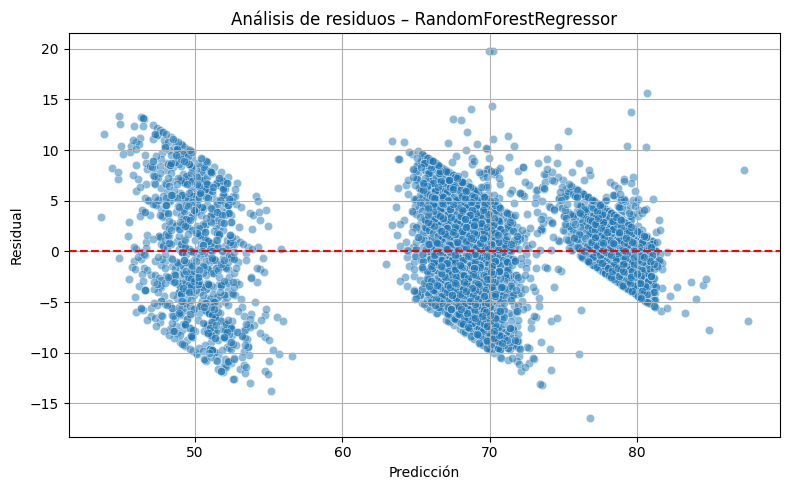

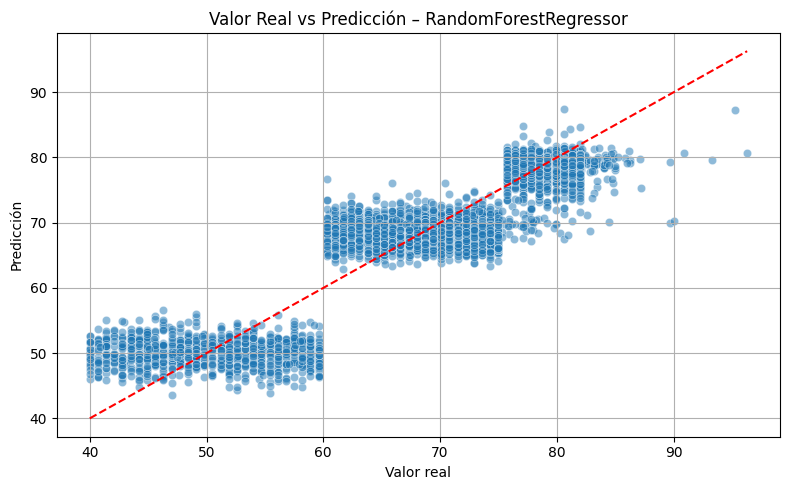

MAE: 3.6150 | RMSE: 20.0312 | R²: 0.8008


In [ ]:
# Usar el modelo de regresión seleccionado (Random Forest)
model_rf = old_benchmark_reg['rf']

# Hacer predicciones
y_pred = model_rf.predict(X_test)
residuals = yreg_test - y_pred

# Análisis de residuos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Análisis de residuos – RandomForestRegressor")
plt.xlabel("Predicción")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicción vs Real
plt.figure(figsize=(8, 5))
sns.scatterplot(x=yreg_test, y=y_pred, alpha=0.5)
plt.plot([yreg_test.min(), yreg_test.max()], [yreg_test.min(), yreg_test.max()], 'r--')
plt.title("Valor Real vs Predicción – RandomForestRegressor")
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.grid(True)
plt.tight_layout()
plt.show()

# Métricas
mae = mean_absolute_error(yreg_test, y_pred)
rmse = mean_squared_error(yreg_test, y_pred)
r2 = r2_score(yreg_test, y_pred)

print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")



#### Resultados numéricos

* MAE (Error Absoluto Medio): 3.6150
  En promedio, el modelo se equivoca por aproximadamente 3.6 unidades al predecir el `contribution_score`. Es un margen de error relativamente bajo considerando la escala de la variable (aproximadamente de 40 a 90).

* RMSE (Raíz del Error Cuadrático Medio): 20.0312
  Aunque parece alto, este valor está influenciado por algunos errores más grandes (outliers), ya que el RMSE penaliza más los errores grandes.

* R² (Coeficiente de determinación): 0.8008
  El modelo explica el 80.08% de la varianza del `contribution_score`, lo cual es un muy buen desempeño para un problema de regresión en un entorno realista.

#### Análisis de residuos

En el primer gráfico (residuos vs. predicción):

* Se observa que los residuos están mayormente concentrados alrededor de 0, lo cual es deseable.
* Sin embargo, hay cierta estructura segmentada en los residuos, se debe a la naturaleza categórica o discreta de algunas variables de entrada. Esto sugiere que el modelo predice "en bloques" característicos de los datos.


#### Valor real vs. predicción

En el segundo gráfico:

* La línea roja representa una predicción perfecta. Los puntos se alinean bastante bien con ella, lo que indica alta correlación entre los valores reales y los predichos.
* Hay cierta dispersión, especialmente en los extremos, pero en general el patrón sigue la diagonal.


### Conclusión

El modelo RandomForestRegressor muestra un buen ajuste con errores bajos y una alta capacidad explicativa. Los residuos sugieren que el modelo podría beneficiarse de un ajuste fino adicional o de una mejor representación de algunas variables, pero su desempeño actual lo hace un candidato sólido para ser utilizado como modelo final en la tarea de regresión del `contribution_score`.


### C.2 Calsifiación binaria - GradientBoostingClassifier

Es el modelo con mejor F1 Score y una buena relación entre precisión, AUC y eficiencia. Aunque RandomForest y Stacking tienen AUC ligeramente superiores, su tiempo de evaluación es más alto. GradientBoosting ofrece un buen equilibrio.




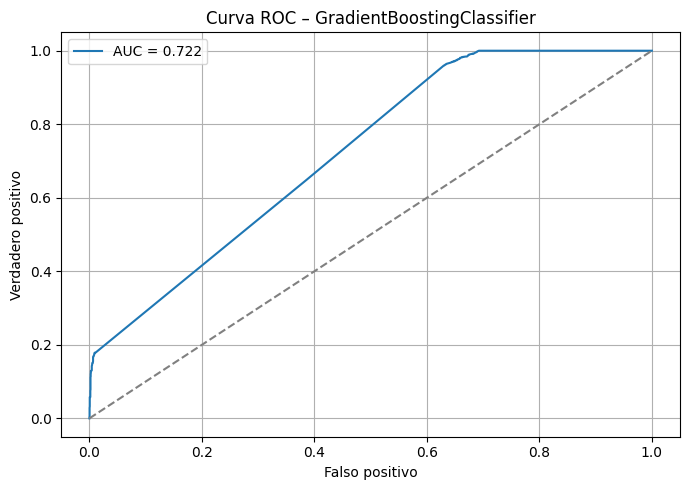

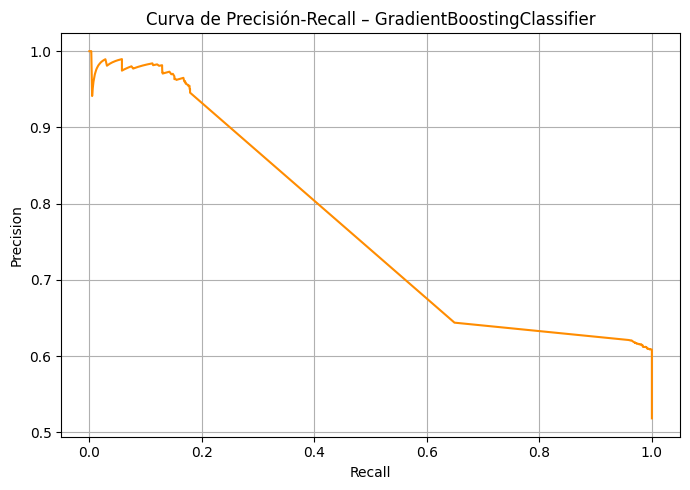

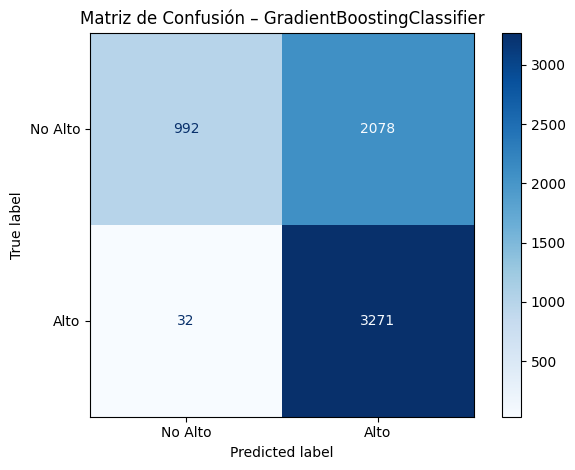

In [ ]:
# Predicciones
gb_bin = boosting_clf

y_pred_bin = gb_bin.predict(X_test)
y_proba_bin = gb_bin.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, _ = roc_curve(ybin_test, y_proba_bin)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Falso positivo")
plt.ylabel("Verdadero positivo")
plt.title("Curva ROC – GradientBoostingClassifier")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Curva de Precisión-Recall
precision, recall, _ = precision_recall_curve(ybin_test, y_proba_bin)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color="darkorange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva de Precisión-Recall – GradientBoostingClassifier")
plt.grid(True)
plt.tight_layout()
plt.show()

# Matriz de confusión
cm = confusion_matrix(ybin_test, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Alto", "Alto"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión – GradientBoostingClassifier")
plt.tight_layout()
plt.show()




#### Curva ROC y AUC*

La Curva ROC muestra una AUC de aproximadamente 0.722, lo cual indica que el modelo tiene una capacidad moderada para discriminar entre las clases "Alto" y "No Alto". Aunque no es perfecta, una AUC superior a 0.7 suele considerarse aceptable en muchos contextos, especialmente en problemas con cierto grado de desequilibrio de clases.

#### Curva de Precisión-Recall

La curva de Precisión-Recall refleja el comportamiento del modelo con respecto a la clase positiva ("Alto"):

* El modelo mantiene una buena precisión (mayor al 0.8) en niveles bajos de recall, lo cual indica que cuando predice un caso como "Alto", suele acertar.
* Sin embargo, conforme incrementa el recall, la precisión se degrada, lo que es esperable en clasificadores que buscan un balance.


#### Matriz de confusión*

La matriz revela lo siguiente:

* El modelo identifica muy bien la clase "Alto" con solo 32 falsos negativos.
* Sin embargo, hay 2078 falsos positivos, es decir, muchos candidatos predichos como "Alto" que en realidad no lo son. Esto puede generar una sobrecarga de validación para los project managers.


#### Conclusión

El modelo se alinea con los objetivos del negocio al maximizar el recall sobre la clase "Alto", lo que implica que la mayoría de los candidatos con alto potencial son detectados. A cambio, hay una cantidad considerable de falsos positivos que podrían mitigarse con un filtrado posterior o reglas de negocio. Es un modelo útil para priorización de talento cuando lo más importante es no dejar fuera perfiles destacados.


### C.3. Clasificación multiclase - StackingClassifier

Fue el modelo con el mejor F1 Score global. Aunque GradientBoosting y XGBoost son más rápidos y cercanos en precisión, Stacking logra una ligera ventaja en rendimiento sin que el costo de evaluación sea prohibitivo.

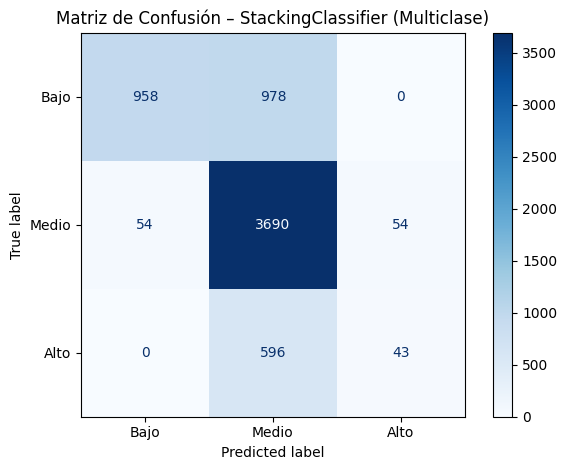

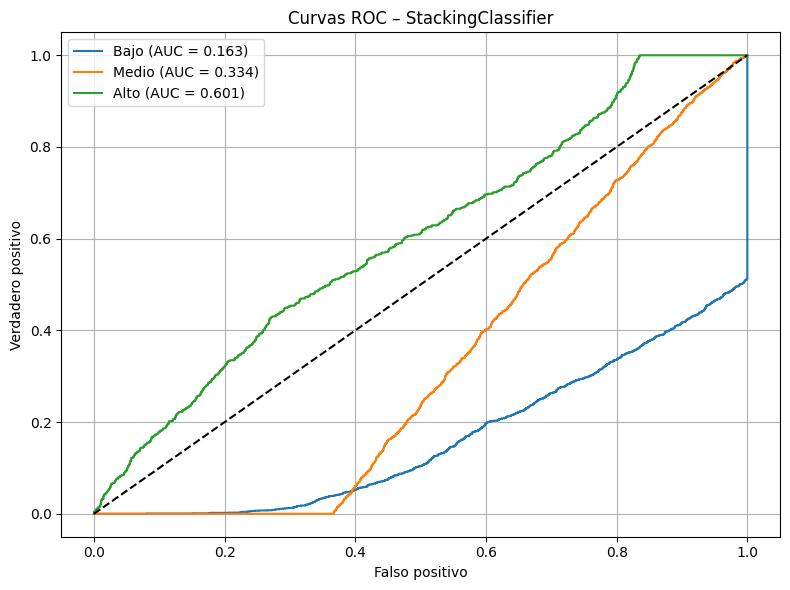

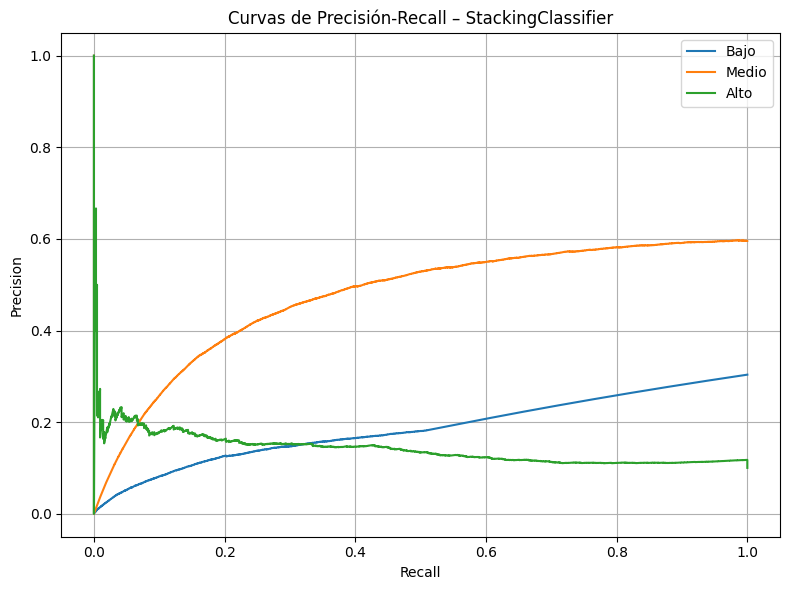

In [ ]:
# Etiquetas
class_names = ["Bajo", "Medio", "Alto"]

# Predicción
y_pred_multi = stack_multi.predict(X_test)
y_proba_multi = stack_multi.predict_proba(X_test)

# Matriz de confusión
cm = confusion_matrix(ymulti_test, y_pred_multi, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión – StackingClassifier (Multiclase)")
plt.tight_layout()
plt.show()

# Binarizar etiquetas para curvas ROC y PR
ymulti_test_bin = label_binarize(ymulti_test, classes=class_names)

# Curvas ROC por clase
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(class_names):
    fpr, tpr, _ = roc_curve(ymulti_test_bin[:, i], y_proba_multi[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Falso positivo")
plt.ylabel("Verdadero positivo")
plt.title("Curvas ROC – StackingClassifier")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Curvas Precisión-Recall por clase
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(ymulti_test_bin[:, i], y_proba_multi[:, i])
    plt.plot(recall, precision, label=f"{class_label}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas de Precisión-Recall – StackingClassifier")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Matriz de Confusión – StackingClassifier (Multiclase)

* La clase "Medio" es la mejor identificada con 3690 observaciones correctamente clasificadas.
* La clase "Alto" presenta un problema de confusión, ya que 596 instancias fueron clasificadas como "Medio" y solo 43 fueron correctamente identificadas.
* La clase "Bajo" muestra también un alto nivel de confusión con "Medio", teniendo más observaciones mal clasificadas (978) que correctamente (958).

Esto indica que el modelo tiende a sesgar sus predicciones hacia la clase "Medio", lo que puede estar influido por la distribución de clases en el dataset.


#### Curvas ROC por clase

* El AUC para la clase "Alto" es de 0.601, lo que sugiere un desempeño moderado.
* Las clases "Bajo" (0.163) y "Medio" (0.334) muestran curvas ROC débiles, lo que implica baja discriminación entre clases para esas etiquetas.

Este comportamiento refuerza que, aunque el modelo muestra una buena precisión general, no está diferenciando bien las clases más bajas (especialmente "Bajo").

#### Curvas de Precisión-Recall

* Para la clase "Medio", la curva muestra un mejor balance entre precisión y recall, lo que confirma su buena predicción.
* La clase "Alto" muestra recall relativamente aceptable pero con baja precisión, indicando que aunque identifica algunos verdaderos positivos, comete muchos falsos positivos.
* La clase "Bajo" muestra ambas métricas por debajo de lo ideal, lo que significa que el modelo casi no acierta en sus predicciones de esta clase.


#### Conclusión

Aunque el modelo `StackingClassifier` se destacó por su F1 ponderado más alto y precisión general (73.6%), estos gráficos revelan que:

* La clase "Medio" domina las predicciones.
* Las clases "Bajo" y especialmente "Alto", que son críticas para decisiones como selección de talento, no están bien diferenciadas.

